In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras import layers, models, optimizers, callbacks, applications
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import os



2025-09-12 13:37:05.028608: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757684225.249676      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757684225.322351      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
TRAIN_DIR = "/kaggle/input/teeth-disease-classification/raw/Training"
VAL_DIR = "/kaggle/input/teeth-disease-classification/raw/Validation"
TEST_DIR = "/kaggle/input/teeth-disease-classification/raw/Testing"

In [3]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS_BASELINE = 35
EPOCHS_TRANSFER = 15


# Get the count of each class of the dataset

In [4]:
def class_counts(folder):
    counts = {}
    for class_name in sorted(os.listdir(folder)):
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len([image for image in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, image))])
    return counts

In [5]:
class_counts(TRAIN_DIR)

{'CaS': 480,
 'CoS': 450,
 'Gum': 359,
 'MC': 540,
 'OC': 324,
 'OLP': 540,
 'OT': 393}

In [6]:
class_counts(TEST_DIR)

{'CaS': 160,
 'CoS': 149,
 'Gum': 120,
 'MC': 180,
 'OC': 108,
 'OLP': 180,
 'OT': 131}

In [7]:
class_counts(VAL_DIR)

{'CaS': 160,
 'CoS': 149,
 'Gum': 119,
 'MC': 180,
 'OC': 108,
 'OLP': 180,
 'OT': 131}

In [8]:
train_sample = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    image_size = IMAGE_SIZE,
    batch_size = 9,
    shuffle = True
)
train_sample

Found 3086 files belonging to 7 classes.


I0000 00:00:1757684246.213930      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757684246.214631      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [9]:
class_names = train_sample.class_names
class_names

['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']

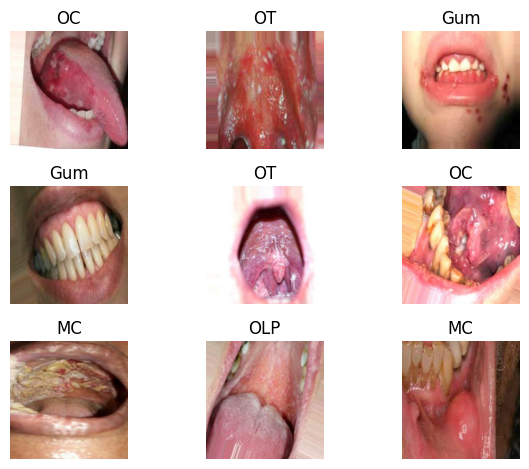

In [10]:
for images, labels in train_sample.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

plt.tight_layout()

# LOAD AND PREPARE DATA

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels = "inferred",
    label_mode = "int",
    image_size = IMAGE_SIZE, 
    batch_size = BATCH_SIZE,
    shuffle = True
    
)

Found 3086 files belonging to 7 classes.


In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    labels = "inferred",
    label_mode = "int",
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels = "inferred",
    label_mode = "int",
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = False
)

Found 1027 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


In [13]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = val_ds.cache().prefetch(AUTOTUNE)


# Preprocessing and Augmentation

In [14]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_image = data_augmentation(tf.expand_dims(images[i], 0))  # add batch dim
        augmented_image = augmented_image[0]  # remove batch dim back
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_image.numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")


NameError: name 'data_augmentation' is not defined

<Figure size 1000x1000 with 0 Axes>

In [ ]:
normalization = layers.Rescaling(1./255)

# Build CNN Model

In [ ]:
def build_CNN(input_shape = (224,224,3), num_classes = 7):
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = normalization(x)

    x = layers.Conv2D(32,3, padding = "same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same",activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(128, 3, padding="same",activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(128, 3, padding="same",activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs, outputs)

In [ ]:
CNN = build_CNN()

In [ ]:
CNN.compile(
    optimizer = optimizers.Adam(learning_rate=1e-4),
    loss = "sparse_categorical_crossentropy",
    metrics= ["accuracy"]
)
CNN.summary()

# Callbacks

In [ ]:
cb = [
    callbacks.EarlyStopping(monitor="val_loss",patience=15, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,patience=5,verbose=1),
    callbacks.ModelCheckpoint("CNN.h5",save_best_only=True,monitor="val_loss")
]

# Train The CNN Model

In [ ]:
history_CNN = CNN.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS_BASELINE,
    callbacks=cb,
)

# Evaluate the CNN

In [ ]:
CNN.evaluate(test_ds)


In [ ]:
y_true = np.concatenate([y.numpy() for x,y in test_ds], axis=0)
y_prob = CNN.predict(test_ds)
y_pred = np.argmax(y_prob, axis=1)


In [ ]:
class_names = sorted(os.listdir(TRAIN_DIR))
print(class_names)

In [ ]:
print(classification_report(y_true, y_pred, target_names = class_names))


# Train EfficientNetB0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:

eff_net = EfficientNetB0(include_top=False, weights = "imagenet",input_shape=(*IMAGE_SIZE,3))
eff_net.trainable=False

inputs = layers.Input(shape=(*IMAGE_SIZE,3))
x = data_augmentation(inputs)
x = layers.Lambda(preprocess_input)(inputs)
x = eff_net(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(7, activation= "softmax",
                       dtype="float32",
                      kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)

eff_model = models.Model(inputs,outputs)

In [ ]:
eff_model.compile(
    optimizer = optimizers.Adam(learning_rate = 1e-4),
    loss = "sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
eff_model.summary()

In [ ]:
history_eff = eff_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks = cb
)

# Fine tune the Efficient net by unfreeze the top 30% of layers of it 

EfficientNet has hundreds of layers. Training all at once can:

Be too slow

Cause overfitting (especially with small dataset)

Break the pre-trained weights if learning rate is too high.

Instead, you unfreeze only the top 30% of layers (the later ones).

Why the later ones? Because:

Early layers detect generic features (edges, textures) → already useful.

Later layers detect task-specific features (shapes, structures) → need adaptation.

In [ ]:
eff_model.trainable = True
fine_tune_eff = int(len(eff_model.layers) * 0.7)
for layer in eff_model.layers[:fine_tune_eff]:
    layer.trainable = False



In [ ]:
eff_model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history_fine = eff_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=35,
    callbacks=cb
)

In [ ]:
y_true = np.concatenate([y.numpy() for x,y in test_ds], axis=0)
y_prob = eff_model.predict(test_ds)
y_pred = np.argmax(y_prob, axis=1)
class_names = sorted(os.listdir(TRAIN_DIR))

print(classification_report(y_true, y_pred, target_names = class_names))


In [ ]:
eff_model.save("efficientnetB0_teeth.h5")

In [ ]:
def plot_history(hists, titles=None):
    plt.figure(figsize=(14,5))
    # accuracy
    plt.subplot(1,2,1)
    for h, label in hists:
        plt.plot(h.history['accuracy'], label=label + " train")
        plt.plot(h.history['val_accuracy'], '--', label=label + " val")
    plt.title("Accuracy")
    plt.legend()
    # loss
    plt.subplot(1,2,2)
    for h, label in hists:
        plt.plot(h.history['loss'], label=label + " train")
        plt.plot(h.history['val_loss'], '--', label=label + " val")
    plt.title("Loss")
    plt.legend()
    plt.show()

plot_history([(history_fine, "EfficientNetB0_Tuned"), (history_eff, "EfficientNetB0"), (history_CNN, "CNN")])
